## Import Desired Library

In [1]:
import os

from __future__ import absolute_import, division, print_function, unicode_literals

from numpy.random import seed
seed(101)

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
%matplotlib inline
print("Running TensorflowVersion: " + str(tf.__version__))

Running TensorflowVersion: 2.5.0


## Select appropriate distribution strategy for hardware

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU: " + str(tpu.master()))
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus)
    print("Running on ",len(gpus)," GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s)


## Setup Strategy Based on Hardware

In [3]:
train_path = "Dataset/Train"
val_path = "Dataset/Validation"
test_path = "Dataset/Test"

train_images = [image for dir,_,sublist in os.walk(train_path) for image in sublist]
val_images = [image for dir,_,sublist in os.walk(val_path) for image in sublist]
test_images = [image for dir,_,sublist in os.walk(test_path) for image in sublist]
num_train_images = len(train_images)
num_val_images = len(val_images)
num_test_images = len(test_images)

IMAGE_SIZE = 224 
EPOCHS = 10

#CLASSES = ['Boat', 'Bus', 'Car', 'Cat', 'Flower', 'Horse']
multi = 16 

#Learning rate scheduling variables
num_units = strategy.num_replicas_in_sync
if num_units == 8:
    BATCH_SIZE = multi * num_units
    VALIDATION_BATCH_SIZE = multi * num_units
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * num_units
    rampup_epochs = 8
    sustain_epochs = 0
    exp_decay = 0.8
elif num_units == 1:
    BATCH_SIZE = multi
    VALIDATION_BATCH_SIZE = multi
    start_lr = 0.00001 #0.00001
    min_lr = 0.00001 #0.00001
    max_lr = 0.0002 #0.0002
    rampup_epochs = 8 #8
    sustain_epochs = 0
    exp_decay = 0.8
else:
    BATCH_SIZE = int(multi/2) * num_units
    VALIDATION_BATCH_SIZE = int(multi/2) * num_units
    start_lr = 0.00001  
    min_lr = 0.00001
    max_lr = 0.00002 * num_units
    rampup_epochs = 11
    sustain_epochs = 0
    exp_decay = 0.8
    
train_steps = int(np.ceil(num_train_images/BATCH_SIZE))
val_steps = int(np.ceil(num_val_images/VALIDATION_BATCH_SIZE))

print("Total Training Images: " + str(num_train_images))
print("Total Validation Images: " + str(num_val_images))
print("Total Test Images: " + str(num_test_images))

print("Train Steps: " + str(train_steps))
print("Val steps: " + str(val_steps))

def display_training_curves(training,validation,title,subplot):
    if subplot%10 == 1:
        plt.subplots(figsize = (10,10),facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
def learningrate_function(epoch):
    if epoch < rampup_epochs:
        lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr
    return lr

def learning_rate_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch : learningrate_function(epoch),verbose = True)
    rng = [i for i in range(EPOCHS)]
    y = [learningrate_function(x) for x in range(EPOCHS)]
    plt.plot(rng,y)
    return lr_callback

Total Training Images: 11400
Total Validation Images: 600
Total Test Images: 600
Train Steps: 713
Val steps: 38


## Define Training, Validation, Test Dataset through Folder

In [4]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_datagen = datagen.flow_from_directory(train_path, 
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE, 
                                            class_mode = 'categorical')

val_datagen = datagen.flow_from_directory(val_path,
                                          target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                          batch_size = VALIDATION_BATCH_SIZE,
                                          class_mode = 'categorical')

test_datagen = datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = 1, 
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 11400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [5]:
CLASSES = list(train_datagen.class_indices.keys())
print(CLASSES)

['Boat', 'Bus', 'Car', 'Cat', 'Flower', 'Horse']


## Define Model Layers

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

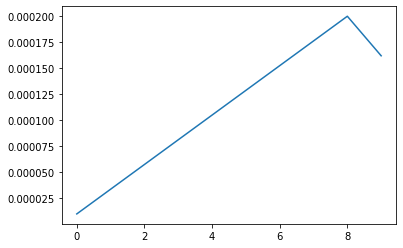

In [6]:
with strategy.scope():        
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False) 
    base_model.trainable = True
    
    model = Sequential([
        base_model,       
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        Dense(6, activation = 'softmax', dtype= tf.float32)
    ])
    
    model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )
    
model.summary()

lr_callback = learning_rate_callback()

## Train the model (you can skip this step if only load the existing model)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
713/713 [==============================] - 241s 312ms/step - loss: 0.5677 - accuracy: 0.8118 - val_loss: 0.2531 - val_accuracy: 0.9150

Epoch 00001: val_accuracy improved from -inf to 0.91500, saving model to model.h5


C:\Users\KikiFade\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.375e-05.
713/713 [==============================] - 157s 220ms/step - loss: 0.3273 - accuracy: 0.8911 - val_loss: 0.1623 - val_accuracy: 0.9433

Epoch 00002: val_accuracy improved from 0.91500 to 0.94333, saving model to model.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 5.75e-05.
713/713 [==============================] - 156s 219ms/step - loss: 0.2319 - accuracy: 0.9210 - val_loss: 0.2042 - val_accuracy: 0.9367

Epoch 00003: val_accuracy did not improve from 0.94333
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 8.125e-05.
713/713 [==============================] - 155s 218ms/step - loss: 0.2018 - accuracy: 0.9316 - val_loss: 0.2586 - val_accuracy: 0.9267

Epoch 00004: val_accuracy did not improve from 0.94333
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000105.
713/713 [==============================] - 156s 219ms/step - lo

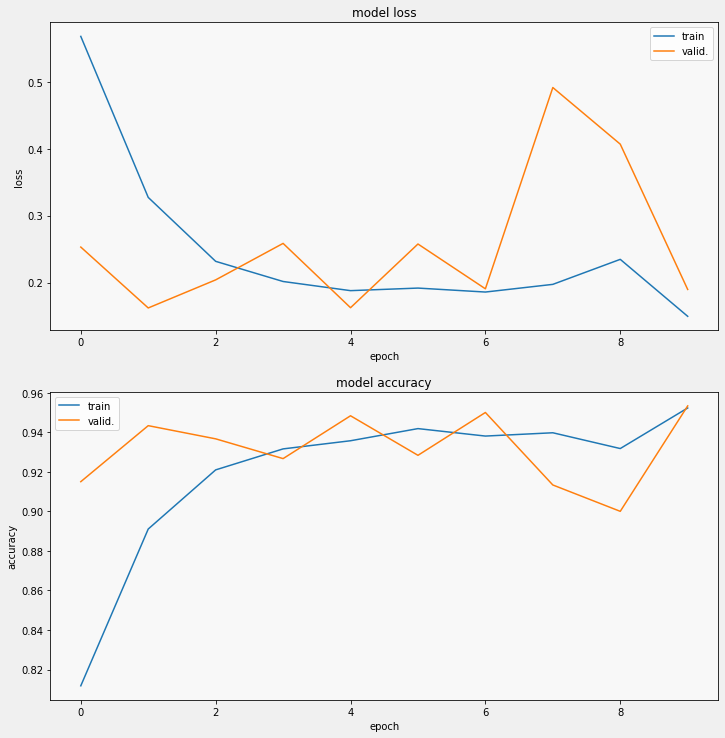

In [7]:
filepath = "model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #,mode='max'

callbacks_list = [checkpoint,lr_callback]

hist = model.fit(train_datagen,
                             steps_per_epoch = train_steps,
                             validation_data = val_datagen,
                             validation_steps = val_steps,
                             epochs = EPOCHS,
                             verbose = 1,
                             callbacks = callbacks_list)



val_loss, val_acc = model.evaluate(val_datagen,steps = num_val_images)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

display_training_curves(hist.history['loss'], hist.history['val_loss'], 'loss', 211) 
display_training_curves(hist.history['accuracy'], hist.history['val_accuracy'], 'accuracy', 212)

## Load Trained Model

In [12]:
model = load_model("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 34,374,214
Trainable params: 34,340,102
Non-trainable params: 34,112
_________________________________________________________________


## Test the accuracy using test dataset

In [13]:
predictions = model.predict(test_datagen, steps= num_val_images, verbose=1)

df_preds = pd.DataFrame(predictions,columns=CLASSES)
#df_preds.head()
y_true = val_datagen.classes

from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=CLASSES)

print(report)

600/600 [==============================] - 10s 16ms/step
              precision    recall  f1-score   support

        Boat       0.92      0.95      0.94       100
         Bus       0.93      0.93      0.93       100
         Car       0.92      0.94      0.93       100
         Cat       0.99      0.97      0.98       100
      Flower       1.00      0.98      0.99       100
       Horse       1.00      0.99      0.99       100

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

